In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import copy
from scipy.sparse import lil_matrix, csr_matrix, identity,spdiags
import scipy.sparse as sparse
from scipy.sparse.linalg import LinearOperator,eigs,spsolve,norm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
from time import time
from numpy.random import default_rng
import math 
import matplotlib.pylab as pl
from scipy import spatial
import scipy
from scipy.sparse import kron
import scipy.linalg as linalg
import ot
import ot.plot

def cosine(v1, v2):
    result = 1 - spatial.distance.cosine(v1, v2);
    return result;

### Define  bounds and essential parameters

In [2]:
#Define the G dictionary with all the variables
#Define the G dictionary with all the variables
G = {
"dt": 0.0005, 
"dx": 6.35,
"sigma": 10,
"b": 8/3, #beta
"r": 28, #rho
"alpha":1e-4, #teleportation parameter
"diff": 0 #diffusion parameter
}

bounds=[[-42.123456456,42.98456879],[-67.236546568,67.9595959898],[-20.22656564,80.232365]]

Xi=[i for i in np.arange(bounds[0][0], bounds[0][1]+1,G["dx"])]
Yi=[i for i in np.arange(bounds[1][0], bounds[1][1]+1,G["dx"])]
Zi=[i for i in np.arange(bounds[2][0], bounds[2][1]+1,G["dx"])]
Xi = np.array(Xi)
Yi = np.array(Yi)
Zi = np.array(Zi)

G['nx'] = len(Xi)
G['ny']  = len(Yi)
G['nz'] = len(Zi)
G["deltas"]=G["dx"]*3.0*(np.random.rand(3, 64) - 0.5)

xv, yv ,zv = np.meshgrid(Xi, Yi,Zi, sparse=False, indexing='ij')
X = np.zeros((G['nx']*G['ny']*G['nz'],3))
X[:,0] = xv.reshape(G['nx']*G['ny']*G['nz'], order='F')
X[:,1] = yv.reshape(G['nx']*G['ny']*G['nz'], order='F')
X[:,2] = zv.reshape(G['nx']*G['ny']*G['nz'], order='F')

G["X"] = X
G["xv"] = xv

# # cost matrix (Duclidean distance) for Wasserstein metric (W2)
# costM = ot.dist(X, X)
# costM /= costM.max()

In [3]:
N1=14; N2=22; N3=16;

### Define the velocity function, i.e., RHS of the Lorenz system

In [4]:
def RHS_vec(y,G):
  # y is a vector of n by 3 representing n points in R^3

  n,_ = np.shape(y)
  f1 = G["sigma"] * (y[:,1]-y[:,0])
  f2 = y[:,0]*(G["r"] - y[:,2])-y[:,1]
  f3 = y[:,0] * y[:,1] - G["b"] * y[:,2] 
  f = np.concatenate((f1.reshape(n,1),f2.reshape(n,1),f3.reshape(n,1)),axis=1)
  # f is n by 3
  # each row of f represent the output of each row of y
  # output all the velocity fields at those n points in one go.
  return f

### Preparing solving the steady-state solution of the continuity equation

In [5]:
def diffmin(x):
    return 1-np.heaviside(x,0)
def diffmax(x):
    return np.heaviside(x,0)
def RHS_Matrix (G,bounds):
    # the output of this function gives the matrix K_mat 
    # as described in the paper Section 3.2

    #Build 'face' mesh - lower faces of cell i,j,k are faces i,j,k
    #Note there is one additional face for the upper cell+1
    Xf=[i-G["dx"]/2 for i in np.arange(bounds[0][0], bounds[0][1]+ G["dx"] + 1 ,G["dx"])]
    Yf=[i-G["dx"]/2 for i in np.arange(bounds[1][0], bounds[1][1]+ G["dx"] + 1 ,G["dx"])]
    Zf=[i-G["dx"]/2 for i in np.arange(bounds[2][0], bounds[2][1]+ G["dx"] + 1 ,G["dx"])]

    nx = G['nx']
    ny = G['ny']
    nz = G['nz']

    #Build face velocity matrices
    Uf = np.zeros((nx+1, ny+1,nz+1))
    Vf = copy.deepcopy(Uf)
    Wf = copy.deepcopy(Uf)

    #Set v = 0 on edges of the boundary to enforce zero-flux boundary condition
    
        
    y_big = np.zeros((nx-1,ny-1,nz-1,3))
    # This is the equivalent of "ndgrid" in Matlab by specifing indexing='ij'  
    y_big[:,:,:,0],y_big[:,:,:,1],y_big[:,:,:,2] = np.meshgrid(Xf[1:-1],Yf[1:-1],Zf[1:-1],indexing='ij')

    #y_big is n by 3 where n= (nx-1)*(ny-1)*(nz-1) is # of points we evaluate the RHS
    y_big = y_big.reshape((nx-1)*(ny-1)*(nz-1),3) 

    # evaluate the velocity at faces of the velocity cells
    Uf[1:-1,1:-1,1:-1] = np.reshape(RHS_vec(y_big + np.ones(((nx-1)*(ny-1)*(nz-1),1))@np.array([0,G['dx']/2,G['dx']/2]).reshape(1,3) , G)[:,0], ((nx-1),(ny-1),(nz-1)))
    Vf[1:-1,1:-1,1:-1] = np.reshape(RHS_vec(y_big + np.ones(((nx-1)*(ny-1)*(nz-1),1))@np.array([G['dx']/2,0,G['dx']/2]).reshape(1,3) , G)[:,1], ((nx-1),(ny-1),(nz-1)))
    Wf[1:-1,1:-1,1:-1] = np.reshape(RHS_vec(y_big + np.ones(((nx-1)*(ny-1)*(nz-1),1))@np.array([G['dx']/2,G['dx']/2,0]).reshape(1,3),  G)[:,2], ((nx-1),(ny-1),(nz-1))) 

    #Build sparse time advance operator K_mat
    #Each row (first index) is the equation for one [i,j,k] cell in terms of +-1 neighbors
    N=nx*ny*nz
    
    # This is the equivalent of "ndgrid" in Matlab by specifing indexing='ij'  
    XXf,YYf,ZZf = np.meshgrid(Xf,Yf,Zf,indexing='ij')
   
    # ufm=Uf[i-1,j-1,k-1]
    ufm = Uf[:-1,:-1,:-1]
    ufm = ufm.flatten(order='F')
    YmX = YYf[:-1,:-1,:-1] - XXf[:-1,:-1,:-1] + G["dx"]/2*np.ones((nx,ny,nz))
    YmX[0,:,:] = 0 
    YmX = YmX.flatten(order='F')

    #  ufp=Uf[i,j-1,k-1]
    ufp = Uf[1:,:-1,:-1]
    ufp = ufp.flatten(order='F')
    YmX2 = YYf[1:,:-1,:-1] - XXf[1:,:-1,:-1] + G["dx"]/2*np.ones((nx,ny,nz))
    YmX2[-1,:,:] = 0
    YmX2 = YmX2.flatten(order='F')
               
    # vfm=Vf[i-1,j-1,k-1]
    vfm = Vf[:-1,:-1,:-1]
    vfm = vfm.flatten(order='F')
    X = XXf[:-1,:-1,:-1] +  G["dx"]/2*np.ones((nx,ny,nz))
    X[:,0,:] = 0
    X = X.flatten(order='F')

    # vfp=Vf[i-1,j,k-1]
    vfp = Vf[:-1,1:,:-1]
    vfp = vfp.flatten(order='F')
    X2 = XXf[:-1,1:,:-1] + G["dx"]/2*np.ones((nx,ny,nz))
    X2[:,-1,:] = 0
    X2 = X2.flatten(order='F')  

    # wfm=Wf[i-1,j-1,k-1]
    wfm = Wf[:-1,:-1,:-1] 
    wfm = wfm.flatten(order='F')
    mZ =  - ZZf[:-1,:-1,:-1] 
    mZ[:,:,0] = 0
    mZ = mZ.flatten(order='F')

    # wfp=Wf[i-1,j-1,k]
    wfp = Wf[:-1,:-1,1:]
    wfp = wfp.flatten(order='F')
    mZ2 = - ZZf[:-1,:-1,1:]
    mZ2[:,:,-1] = 0
    mZ2 = mZ2.flatten(order='F')

    # K_s is the derivative of T1
    T1 = spdiags(np.array([-np.minimum(0,ufp), np.minimum(0,ufm)- np.maximum(0,ufp), np.maximum(0,ufm)]), np.array([-1,0,1]), N, N); 
    K_s = spdiags(np.array([-diffmin(ufp)*YmX2,    diffmin(ufm)*YmX - diffmax(ufp)*YmX2 , diffmax(ufm)*YmX]), np.array([-1,0,1]), N, N); 

    # K_r is the derivative of T2
    T2 = spdiags(np.array([-np.minimum(0,vfp), np.minimum(0,vfm) - np.maximum(0,vfp), np.maximum(0,vfm)]), np.array([-nx, 0 ,nx]), N, N); 
    K_r = spdiags(np.array([- diffmin(vfp)*X2,         diffmin(vfm)*X - diffmax(vfp)*X2 ,      diffmax(vfm)*X]), np.array([-nx, 0 ,nx]), N, N); 

    # K_b is the derivative of T3
    T3 = spdiags(np.array([-np.minimum(0,wfp), np.minimum(0,wfm) - np.maximum(0,wfp), np.maximum(0,wfm)]), np.array([-nx*ny, 0, nx*ny]), N, N); 
    K_b = spdiags(np.array([- diffmin(wfp)*mZ2,       diffmin(wfm)*mZ - diffmax(wfp)*mZ2 ,    diffmax(wfm)*mZ]), np.array([-nx*ny, 0, nx*ny]), N, N); 

    K_mat = (T1.transpose() + T2.transpose()+ T3.transpose())/G['dx']*G['dt']
    K_s = K_s.transpose()/G['dx']*G['dt']
    K_r = K_r.transpose()/G['dx']*G['dt']
    K_b = K_b.transpose()/G['dx']*G['dt']
    return  K_mat,K_s,K_r,K_b

In [6]:
K_mat, _, _, _ = RHS_Matrix(G,bounds)

In [7]:
# Check that K_mat sum over all the columns gives 0
# Therefore, given e = [1,1,...,1], e p^{l+1}=e p^{l} + e K_mat p^{l} = e p^{l}
# mass conservation is ensured
K_mat = K_mat.tocsr()
K_mat.sum(axis = 0)

matrix([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -3.46944695e-18, -1.04083409e-17,  0.00000000e+00]])

In [8]:
def FWD(G,bounds):
    # obtain the matrices
        
    K_mat, K_s, K_r, K_b = RHS_Matrix(G,bounds)
    K_mat = K_mat.tocsr()
    K_s = K_s.tocsr()
    K_r = K_r.tocsr()
    K_b = K_b.tocsr()

    # scale to positive
    mnV = abs(K_mat.min(axis=0).min())       
    N = K_mat.shape[0]
    speyeN = identity(N).tocsr()
    M = speyeN +(1/(2*mnV))*K_mat
    e = np.ones(N,)

    ######### solves Mx = x  #########

    # we "regularize" the matrix A by using the teleportation trick
    # ---- M  ===> (1-a) M + a/N * e e^T, e = [1,1,1,...,1]^T
    # Correspondingly, the derivative matrices change        
    K_s = K_s * (1-G["alpha"])*(1/(2*mnV))
    K_r = K_r *(1-G["alpha"])*(1/(2*mnV))
    K_b = K_b * (1-G["alpha"])*(1/(2*mnV))
    ###########################################################################    
    ##### Method #1  mv(x) = (1-a)Mx + a/N e e^T x = (1-a)Mx + a/N e sum(x)####
    ###########################################################################
    # mv = lambda x: (1-G["alpha"])*(M*x)  + (G["alpha"]/N)*sum(x)*e;

    # teleportation = LinearOperator((N,N), matvec=mv)
    # d, Peq = eigs(teleportation, k=1)

    # Peq = Peq.reshape((G['nx'],G['ny'],G['nz']), order='F')
    # if np.abs(np.real(d)-1) > 1e-6:
    #     print ("Unsuccessful eigen solve")

    #############################################################
    #### Method #2: Richardson iteration for solving Mx = x #####
    # #############################################################
    # x = np.zeros(N,) # initial guess
    # tol = 1e-2
    # for j in range(1,math.ceil(-math.log(1/tol)/math.log(1-G["alpha"]))):
    #     x = (1-G["alpha"])*(M*x) + G["alpha"]/N *sum(x)*e
    # x = np.real(x)
    # x = np.sign(x[0])*x
    # Peq = x.reshape((G['nx'],G['ny'],G['nz']), order='F')
    
    ########################################################
    ##### Method #3: Directly invert the linear system ##### 
    ########################################################
    ## This method is the FASTEST so far ##
    ## Note that (1-a)Mx + a/N e sum(x) = (1-a)Mx + a/N e since we want sum(x)=1
    ## Thus, finding x becomes ( (1-a)M - I )x  = -a/N e, while e^T x = 1

    # The following four lines of code guarantee that the solution sums to 1.
    # The following lines of code already guarantee that the solution sums to 1.
    A = (1-G["alpha"])*M - speyeN
    b = -(G["alpha"]/N)*e

    x = spsolve(A, b )
    Peq = x.reshape((G['nx'],G['ny'],G['nz']), order='F')


    ##### Reshape the solution
    Peq0 = Peq * 0
    Peq0[1:-1, 1:-1,1:-1] = Peq[1:-1, 1:-1,1:-1]
    Peq0 = Peq0/Peq0.sum()
    Peq0 = Peq0.flatten(order = 'F')
    
    dgdrho = (1-G["alpha"])*M;
    dgdrho.data+=G["alpha"]/N;
    dgdrho = dgdrho - speyeN;

    # return the transpose of matrix (1-G["alpha"])*M - speyeN for adjoint eqn.
    return (1-G["alpha"])*M.transpose() - speyeN, Peq0, x, K_s, K_r, K_b, dgdrho

### Forward Solve: given parameters, and return the stationary distribution (pdf)

In [9]:
G["sigma"]= 10
G["r"]= 28
G["b"]= 8/3

start=time()
A,_,Peq_true,K_s, K_r, K_b, dgdrho  = FWD(G,bounds)
end=time()
print("time to solve the forward problem: ")
print(end-start)


time to solve the forward problem: 
0.4578261375427246


### Adjoint Method to Obtain the Gradient: given parameters and pdf, and return adjoint variable and the gradient (5.8)

In [10]:
G["sigma"]= 11
G["r"]= 28
G["b"]= 8/3

#### 1. Solve the forward problem
A,_,Peq, K_s,K_r, K_b, dgdrho = FWD(G,bounds)
#### 2. compute the loss function

## L2 distance
u = Peq - Peq_true
cost = np.linalg.norm(Peq - Peq_true)**2 *0.5

## W2 distance
# _,log = ot.lp.emd(Peq, Peq_true, costM, numItermax=1000000, log=True)
# cost = log['cost']
# u = log['u']

#### 3. Solve the adjoint equation
sol = spsolve(A,-u + u.dot(Peq))
print(sol.sum())

#### 4. compute the gradient
grad1_adj =   sol.dot(K_s*Peq)
grad2_adj =   sol.dot(K_r*Peq)
grad3_adj =   sol.dot(K_b*Peq)
print(grad1_adj)
print(grad2_adj)
print(grad3_adj)
eta_adj = np.array([grad1_adj, grad2_adj, grad3_adj]);

-4.2246028897352517e-10
8.677867644098512e-05
-2.0548347227610024e-05
-0.00011794355020396044


### Implicit Function Method to Obtain the Gradient: given parameters and pdf, and compute gradient following (5.6)

In [11]:
G["sigma"]= 11
G["r"]= 28
G["b"]= 8/3

#### 1. Solve the forward problem
A,_,Peq, K_s,K_r, K_b, dgdrho = FWD(G,bounds)
#### 2. compute the loss function

#### 2. Solve the "adjoint" equation
#### Note that the solution is exactly   d Peq / d \theta 

B= np.asarray([-K_s*Peq, -K_r*Peq, -K_b*Peq]).transpose()
#drho/dTheta 3 col vector
drhodtheta = spsolve(A.transpose(),B)
print(drhodtheta.sum(axis=0))

### 3. Compute the objective function and dJ/d Peq (Frechet derivative)

## L2 distance
u = Peq - Peq_true
cost = np.linalg.norm(Peq - Peq_true)**2 *0.5

## W2 distance
# _,log = ot.lp.emd(Peq, Peq_true, costM, numItermax=1000000, log=True)
# cost = log['cost']
# u = log['u']

#### 4. compute the gradient
grad1_implicit =   drhodtheta[:,0].dot(u)
grad2_implicit =   drhodtheta[:,1].dot(u)
grad3_implicit =   drhodtheta[:,2].dot(u)
print(grad1_implicit)
print(grad2_implicit)
print(grad3_implicit)
eta_implicit = np.array([grad1_implicit, grad2_implicit, grad3_implicit])

[ 5.08620923e-15 -6.74113543e-14  3.31679129e-14]
8.677867644099103e-05
-2.0548347227631925e-05
-0.00011794355020394319


### Two different methods but produce the same gradient!

In [12]:
print(abs(grad1_implicit - grad1_adj) + abs(grad2_implicit-grad2_adj)+ abs(grad3_implicit-grad3_adj) ) 

4.506215279392878e-17


### Compute the L2 GD direction throught Least Square Minimization

We want to minimize:

$$\eta^l = argmin_{\eta}|| \phi^l + \zeta \eta ||^2$$

In [13]:
Q, R = linalg.qr(drhodtheta, mode = 'economic');
eta_l2 = np.linalg.solve(R, -Q.T@u);
print(eta_l2);

[-0.00106812  0.00150138  0.00570889]


### Compute the L2 GD direction through Kernel Matrix

In [14]:
## Compute the l2 descent dir through the kernel matrix and compare
def Gl2func(ksi):
    dgdtheta = np.asarray([K_s*Peq, K_r*Peq, K_b*Peq]).transpose();
    B = -dgdtheta@ksi;
    Ksi_rho = spsolve(dgdrho, B);
    landa = spsolve(dgdrho.T, -Ksi_rho);
    return dgdtheta.T@landa;

In [15]:
##define the linear operator 
LO = sparse.linalg.LinearOperator((3, 3), matvec=Gl2func);
##define the initial starting point
initial_x = -eta_adj;
eta_l2_gmres,_ = sparse.linalg.gmres(LO, -eta_implicit, x0=initial_x, tol=1e-5);

In [16]:
print(cosine(eta_l2_gmres, eta_l2));
print(eta_l2_gmres)

0.9999999999643594
[-0.00106769  0.00150077  0.00570672]


### Compute L2 Gradient Direction using Hutchinson Method

In [17]:
N=N1*N2*N3;
def Hutchinson_compute(m, rho, A, dmdt1, dmdt2, dmdt3):
    N = rho.shape[0];
    H = np.random.normal(0, 1, size = [N, m]);
    One = np.ones(N);
    P = np.outer(One, H.T@rho) -H;
    Landa = spsolve(A, P);
    T1 = Landa.T@(dmdt1*rho);
    T2 = Landa.T@(dmdt2*rho);
    T3 = Landa.T@(dmdt3*rho);
    result = np.array([H@T1, H@T2, H@T3]).T;
    return result/m;

In [24]:
#compute the gradient using hutchinson method
drhodtheta_hut = Hutchinson_compute(300, Peq, A, K_s, K_r, K_b);
#compute the l2 descent direction using qr factorization
Q, R = linalg.qr(drhodtheta_hut, mode = 'economic');
eta_l2_hut = np.linalg.solve(R, -Q.T@u);
print(eta_l2_hut);

[-9.67005148e-05  1.20174855e-04  2.81336831e-04]


In [25]:
cosine(eta_l2, eta_l2_hut)

0.9818737500660443

In [20]:
eta_cos = [];
grad1_cos=[]; grad2_cos=[]; grad3_cos=[];
M = [60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900, 960, 1020, 1080, 1140, 1200];
for i in range(20):
    print(i);
    m = M[i];
    drhodtheta_hut = Hutchinson_compute(m, Peq, A, K_s, K_r, K_b);
    Q, R = linalg.qr(drhodtheta_hut, mode = 'economic');
    eta_l2_hut = np.linalg.solve(R, -Q.T@u);
    eta_cos.append(cosine(eta_l2, eta_l2_hut));
    grad1_cos.append(cosine(drhodtheta_hut[:, 0], drhodtheta[:, 0]));
    grad2_cos.append(cosine(drhodtheta_hut[:, 1], drhodtheta[:, 1]));
    grad3_cos.append(cosine(drhodtheta_hut[:, 2], drhodtheta[:, 2]));

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


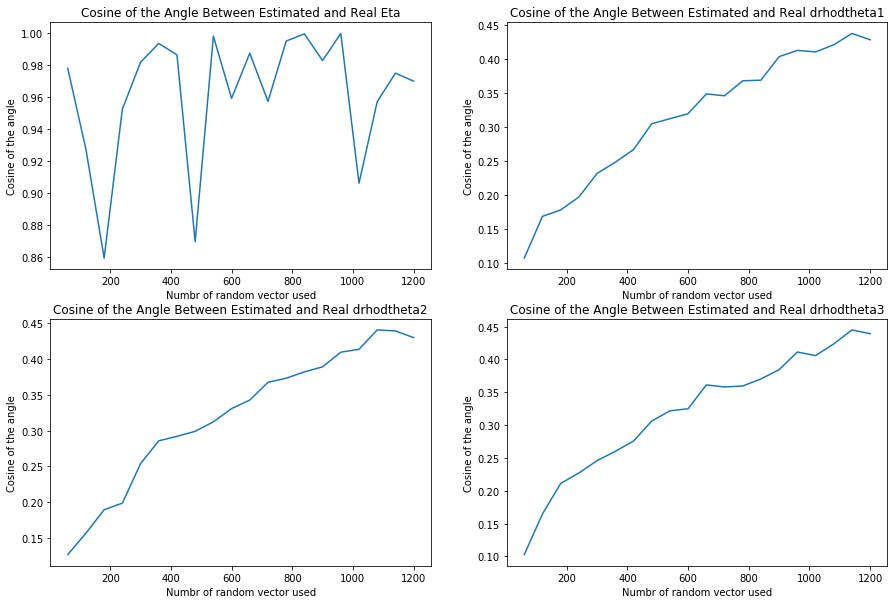

In [21]:
f, ax = plt.subplots(2,2,figsize=(15,10));
ax[0][0].plot(M, eta_cos);
ax[0][0].set_title("Cosine of the Angle Between Estimated and Real Eta");
ax[0][0].set_xlabel("Numbr of random vector used");
ax[0][0].set_ylabel("Cosine of the angle");
ax[0][1].plot(M, grad1_cos);
ax[0][1].set_title("Cosine of the Angle Between Estimated and Real drhodtheta1");
ax[0][1].set_xlabel("Numbr of random vector used");
ax[0][1].set_ylabel("Cosine of the angle");
ax[1][0].plot(M, grad2_cos);
ax[1][0].set_title("Cosine of the Angle Between Estimated and Real drhodtheta2");
ax[1][0].set_xlabel("Numbr of random vector used");
ax[1][0].set_ylabel("Cosine of the angle");
ax[1][1].plot(M, grad3_cos);
ax[1][1].set_title("Cosine of the Angle Between Estimated and Real drhodtheta3");
ax[1][1].set_xlabel("Numbr of random vector used");
ax[1][1].set_ylabel("Cosine of the angle");

In [33]:
eta_cos = []; Matrix_norm=[];
#M = [60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900, 960, 1020];
M = [60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720];
for i in range(len(M)):
    print(i);
    m = M[i];
    m_norm = 0; a_cos = 0;
    for j in range(40):
        drhodtheta_hut = Hutchinson_compute(m, Peq, A, K_s, K_r, K_b);
        Q, R = linalg.qr(drhodtheta_hut, mode = 'economic');
        eta_l2_hut = np.linalg.solve(R, -Q.T@u);
        a_cos+= cosine(eta_l2, eta_l2_hut);
        m_norm+= np.linalg.norm(drhodtheta-drhodtheta_hut, ord=2);
    m_norm/=40; a_cos/=40;
    eta_cos.append(a_cos);
    Matrix_norm.append(m_norm);

0
1
2
3
4
5
6
7
8
9
10
11


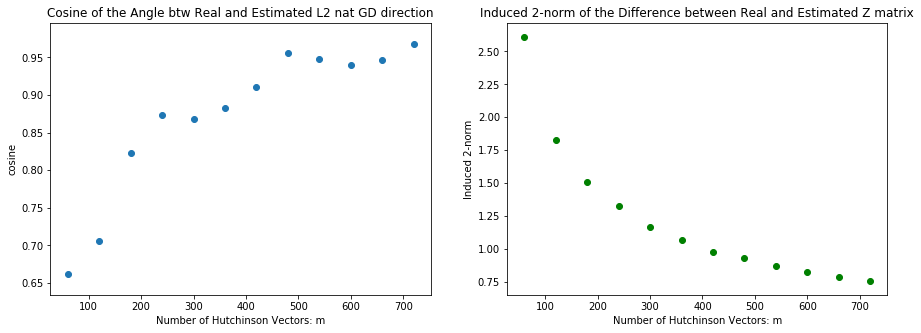

In [55]:
f, ax = plt.subplots(1,2,figsize=(15,5));
ax[0].scatter(M, eta_cos);
ax[1].scatter(M, Matrix_norm, c='green');
ax[0].set_xlabel("Number of Hutchinson Vectors: m");
ax[1].set_xlabel("Number of Hutchinson Vectors: m");
ax[0].set_ylabel('cosine');
ax[1].set_ylabel('Induced 2-norm');
ax[0].set_title('Cosine of the Angle btw Real and Estimated L2 nat GD direction');
ax[1].set_title('Induced 2-norm of the Difference between Real and Estimated Z matrix');
plt.savefig("Huthinson_L2_performance.png", dpi=200)

# Compute the $W_2$ Natural Gradient Direction

In [23]:
##returns a lil sparse matrix
def small_A(N):
    diags = np.array([-1, 1]);
    data = [-np.ones(N), np.ones(N)];
    B1 = spdiags(data, diags, N, N);
    ##change few entries in this matrix
    B1 = sparse.lil_matrix(B1);
    B1[0, 0] = 1; B1[0, 1] = 0;
    B1[-1, -1] = 1; B1[-1, -2] = 0;
    return B1;

##discretization in 3D
##N1, N2, N3 must all be positive for this matrix to be invertible
def discretize(N1, N2, N3, dx, dy, dz):
    B1 = small_A(N1);
    B2 = small_A(N2);
    B3 = small_A(N3);
    A1 = kron(np.identity(N2*N3), B1)/(2*dx);
    C = kron(B2, np.identity(N1));
    A2 = kron(np.identity(N3), C)/(2*dy);
    A3 = kron(B3, np.identity(N1*N2))/(2*dz);
    A = sparse.vstack([A1, A2, A3]);
    return [A.toarray(), A];  

A_dis, A_dis_sp = discretize(N1, N2, N3, G['dx'], G['dx'], G['dx']);

In [24]:
##compute the matrix B=AP^-1
#N1, N2, N3 are the discretization numbers in three direction
#p is the discretized value of the model in each grid points
#A is the SPARSE discretization matrix that acts as a 
#convergence operator
#it returns a B matrix and the Pinv matrix
def Bmatrix(N1, N2, N3, p, A):
    #modify the matrix A
    A = A.T;
    #the diagonal is the square root of the model in
    #every inner discretization grid point
    diagonal = p**0.5;
    data = np.array([diagonal]);
    #compute the matrix P^-1
    N = N1*N2*N3;
    sig = spdiags(data, np.array([0]), N, N);
    Pinv = kron(identity(3), sig);
    B = A@Pinv;
    return [B, Pinv];   

In [25]:
B, pinv = Bmatrix(N1, N2, N3, Peq, A_dis)

## Get the W2 Descent Direction by Solving 2 Least Square Linear System
First, matrix Y is the least square solution of:
$$BY = -\frac{d\rho}{d\theta}$$
where $B = AP$ and P is the matrix with $\sqrt{\rho}$ in its diagonal.

Then we want to solve the following least square linear system:
$$Y\eta^{W} = -\sqrt{\rho}\nabla\frac{dJ}{d\rho}$$


In [27]:
import sparseqr

In [28]:
def W2_dir(N1, N2, N3, p, A, dfdrho, drhodtheta):
    ##reduce the drhodtheta
    B, Pinv = Bmatrix(N1, N2, N3, p, A);
    Y1 = sparse.linalg.lsqr(B, -drhodtheta[:, 0], 
                        atol=1e-14,btol=1e-14)[0];
    Y2 = sparse.linalg.lsqr(B, -drhodtheta[:, 1], 
                        atol=1e-14,btol=1e-14)[0];
    Y3 = sparse.linalg.lsqr(B, -drhodtheta[:, 2], 
                        atol=1e-14,btol=1e-14)[0];
    Y = np.array([Y1, Y2, Y3]).T;
    PinvA = Pinv*A;
    dfdrho_sp = sparse.csr_matrix(dfdrho);
    RHS = PinvA*(dfdrho_sp.T);
    ita_w2 = sparseqr.solve(sparse.csr_matrix(Y), RHS).toarray();
    return np.array([ita_w2[0][0], ita_w2[1][0], ita_w2[2][0]]);

In [29]:
eta_w2_lsq = W2_dir(N1, N2, N3, Peq, A_dis_sp, u, drhodtheta);
print(eta_w2_lsq);

[-7.99052689e-09  1.35758123e-08  4.81962785e-08]


## Get $W_2$ direction through the kernel matrix:
$$\eta^W = -(Y^TY)^{-1}\frac{dJ}{d\theta}$$

In [30]:
##we use the same Y computed in the previous section
B, Pinv = Bmatrix(N1, N2, N3, Peq, A_dis_sp);
Y1 = sparse.linalg.lsqr(B, -drhodtheta[:, 0], 
                        atol=1e-14,btol=1e-14)[0];
Y2 = sparse.linalg.lsqr(B, -drhodtheta[:, 1], 
                        atol=1e-14,btol=1e-14)[0];
Y3 = sparse.linalg.lsqr(B, -drhodtheta[:, 2], 
                        atol=1e-14,btol=1e-14)[0];
Y = np.array([Y1, Y2, Y3]).T;

In [31]:
eta_w2 = -np.linalg.inv(Y.T@Y)@eta_implicit;
print(eta_w2);
print(cosine(eta_w2, eta_w2_lsq))

[-7.99052689e-09  1.35758123e-08  4.81962785e-08]
0.9999999999999999


## Get $W_2$ Descent Direction through Hutchinson Method

In [32]:
BBtinv = sparse.linalg.inv((B*B.T).tocsc())
B_dagger = B.T*BBtinv;

def hut_w2(N1, N2, N3, m):
    N=N1*N2*N3;
    B, Pinv = Bmatrix(N1, N2, N3, Peq, A_dis_sp);
    ##generate m random vectors
    H = np.random.normal(0, 1, size=[N, m]);
    ##compute matrix W
    W = -B_dagger@H;
    # ##solve the adjoint equation and get lambda
    RHS = -H + H.T@Peq;
    # ##use A instead of dgdrho
    Landa = spsolve(A.tocsr(), RHS);
    # ##do the estimation and get Hm(Y)
    dgdtheta = np.array([K_s*Peq, K_r*Peq, K_b*Peq]).T;
    Y_est = W@(Landa.T@dgdtheta)/m;
    # ##solve the least square linear system and get eta_w2
    PinvA = Pinv*A_dis_sp; #<- sqrt(p)*div
    RHS = PinvA@(u.T);
    q, r = np.linalg.qr(Y_est);
    eta_w2_hut = np.linalg.solve(r, q.T@RHS);
    return eta_w2_hut, cosine(eta_w2_hut, eta_w2);

In [168]:
##let's record the output for 
M = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550,
    600, 650, 700, 750, 800, 850, 900, 950, 1000];
dir_w2_dict = {50: 0, 100: 0, 150: 0, 200: 0, 250: 0, 300: 0, 
              350: 0, 400: 0, 450: 0, 500: 0, 550: 0,
    600: 0, 650: 0, 700: 0, 750: 0, 800: 0, 850: 0, 900: 0, 
               950: 0, 1000: 0};
score_dict = {50: 0, 100: 0, 150: 0, 200: 0, 250: 0, 300: 0, 
              350: 0, 400: 0, 450: 0, 500: 0, 550: 0,
    600: 0, 650: 0, 700: 0, 750: 0, 800: 0, 850: 0, 900: 0, 
               950: 0, 1000: 0};
##Let's do 400 simulations for each m

In [188]:
for m in M:
    print(m);
    direct_list = [];
    score_list = [];
    for i in range(40):
        direct, score = hut_w2(N1, N2, N3, m);
        direct_list.append(direct);
        score_list.append(score);
    dir_w2_dict[m] = np.array(direct_list);
    score_dict[m] = np.array(score_list);

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [227]:
np.save("dir_w2_dict.npy", dir_w2_dict);
np.save("score_dict.npy", score_dict);

In [169]:
dir_w2_dict = np.load("dir_w2_dict.npy", allow_pickle=True);
dir_w2_dict = dir_w2_dict[()];
score_dict = np.load("score_dict.npy", allow_pickle=True);
score_dict = score_dict[()];

In [31]:
##plot the statistics of our simulations
##we create an array to store the average score of each m
avg_score = [];
##we also want to record the percentage of the outputs that are
##>95; >85 >75
stat_75 = []; stat_85 = []; stat_95 = [];
for key in score_dict:
    avg_score.append(score_dict[key].mean());
    stat_75.append(np.count_nonzero(score_dict[key] > .75));
    stat_85.append(np.count_nonzero(score_dict[key] > .85));
    stat_95.append(np.count_nonzero(score_dict[key] > .95));
stat_75 = np.array(stat_75)/40;
stat_85 = np.array(stat_85)/40;
stat_95 = np.array(stat_95)/40;
avg_score = np.array(avg_score);

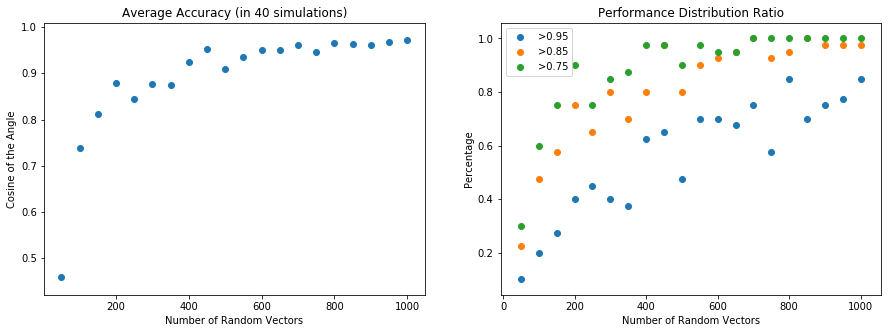

In [32]:
f, ax = plt.subplots(1,2,figsize=(15,5));
ax[0].scatter(range(50, 1050, 50), avg_score);
ax[0].set_xlabel("Number of Random Vectors");
ax[0].set_ylabel("Cosine of the Angle");
ax[1].scatter(range(50, 1050, 50), stat_95, label='>0.95');
ax[1].scatter(range(50, 1050, 50), stat_85, label='>0.85');
ax[1].scatter(range(50, 1050, 50), stat_75, label='>0.75');
ax[1].set_xlabel("Number of Random Vectors");
ax[1].set_ylabel("Percentage");
ax[1].legend()
ax[0].set_title("Average Accuracy (in 40 simulations)");
ax[1].set_title("Performance Distribution Ratio");
plt.savefig("Huthinson_W2_performance.png", dpi=200)

## Compute the $W_2$ Descent direction through the GMRES

In [170]:
BBtinv = sparse.linalg.inv((B*B.T).tocsc())
B_dagger = B.T*BBtinv;

#define the linear operator ksi -> Gw2 * ksi
def Gw2func(ksi):
    print("Gw2func");
    dgdtheta = np.asarray([K_s*Peq, K_r*Peq, K_b*Peq]).T;
    B_mat = -dgdtheta@ksi;
    Ksi_rho = spsolve(A.T, B_mat);
    landa = spsolve(A, -B_dagger.T*(B_dagger*Ksi_rho));
    return dgdtheta.T@landa;

In [171]:
##define the linear operator 
LO_w2 = sparse.linalg.LinearOperator((3, 3), matvec=Gw2func);
##define the initial starting point
initial_x = -eta_adj;
start = time();
eta_w2_gmres,_ = sparse.linalg.gmres(LO_w2, -eta_implicit, x0=initial_x, tol=1e-8);
end = time();
print(end-start)

Gw2func
Gw2func
Gw2func
Gw2func
Gw2func
Gw2func
Gw2func
0.8914749622344971


In [172]:
print(eta_w2)
print(eta_w2_gmres)
cosine(eta_w2_gmres, eta_w2)

[-7.99052689e-09  1.35758123e-08  4.81962785e-08]
[-7.99052688e-09  1.35758123e-08  4.81962785e-08]


1.0

In [53]:
M = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550,
    600, 650, 700, 750, 800, 850, 900, 950, 1000];
time_list = [];
for m in M:
    print(m)
    start = time();
    hut_w2(N1, N2, N3, m);
    end = time();
    time_list.append(end-start);
    

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


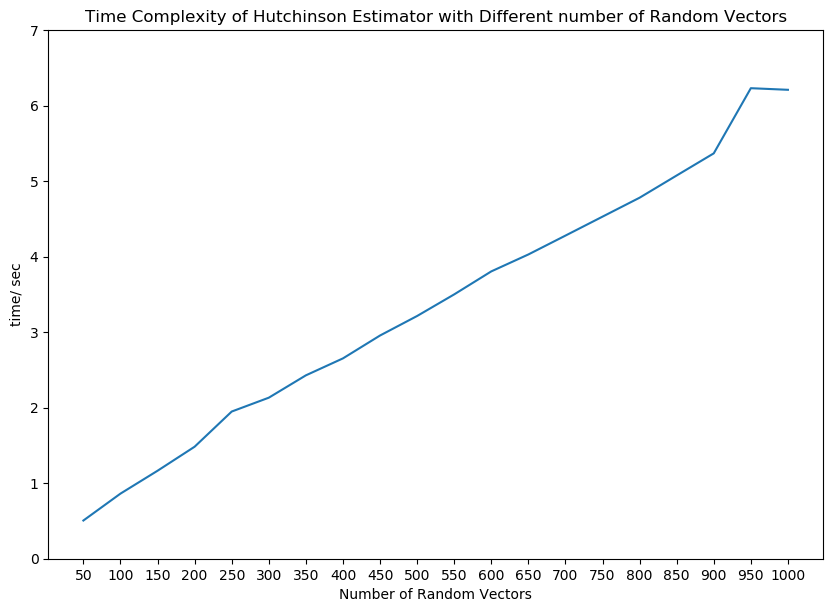

In [67]:
plt.figure(figsize=(10, 7), dpi=100)
plt.plot(range(50, 1050, 50), time_list);
plt.xticks(M);
plt.yticks(range(0, 8));
plt.xlabel("Number of Random Vectors");
plt.ylabel("time/ sec");
plt.title("Time Complexity of Hutchinson Estimator with Different number of Random Vectors");
plt.savefig("time.png", dpi=300);

Option 2: Random Draws in the 

In [173]:
def w2_hut_2(N1, N2, N3, m):
    N = N1*N2*N3;
    B, Pinv = Bmatrix(N1, N2, N3, Peq, A_dis_sp);
    ##generate m random vectors for W
    W = np.random.normal(0, 1, size=[N*3, m]);
    ##compute the matrix H, H = B_dagger.T * W
    H = B_dagger.T*W;
    # ##solve the adjoint equation and get lambda
    RHS = -H + H.T@Peq;
    # ##use A instead of dgdrho
    Landa = spsolve(A.tocsr(), RHS);
    # ##do the estimation and get Hm(Y)
    dgdtheta = np.array([K_s*Peq, K_r*Peq, K_b*Peq]).T;
    Y_est = W@(Landa.T@dgdtheta)/m;
    # ##solve the least square linear system and get eta_w2
    PinvA = Pinv*A_dis_sp; #<- sqrt(p)*div
    RHS = -PinvA@(u.T);
    q, r = np.linalg.qr(Y_est);
    eta_w2_hut = np.linalg.solve(r, q.T@RHS);
    return eta_w2_hut, cosine(eta_w2_hut, eta_w2);

In [103]:
##let's record the output for 
M = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550,
    600, 650, 700, 750, 800, 850, 900, 950, 1000];
dir_w2_dict2 = {50: 0, 100: 0, 150: 0, 200: 0, 250: 0, 300: 0, 
              350: 0, 400: 0, 450: 0, 500: 0, 550: 0,
    600: 0, 650: 0, 700: 0, 750: 0, 800: 0, 850: 0, 900: 0, 
               950: 0, 1000: 0};
score_dict2 = {50: 0, 100: 0, 150: 0, 200: 0, 250: 0, 300: 0, 
              350: 0, 400: 0, 450: 0, 500: 0, 550: 0,
    600: 0, 650: 0, 700: 0, 750: 0, 800: 0, 850: 0, 900: 0, 
               950: 0, 1000: 0};
##Let's do 400 simulations for each m

In [104]:
for m in M:
    print(m);
    direct_list = [];
    score_list = [];
    for i in range(40):
        direct, score = w2_hut_2(N1, N2, N3, m);
        direct_list.append(direct);
        score_list.append(score);
    dir_w2_dict2[m] = np.array(direct_list);
    score_dict2[m] = np.array(score_list);

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [105]:
np.save("dir_w2_dict2.npy", dir_w2_dict2);
np.save("score_dict2.npy", score_dict2);

In [174]:
dir_w2_dict2 = np.load("dir_w2_dict2.npy", allow_pickle=True);
dir_w2_dict2 = dir_w2_dict2[()];
score_dict2 = np.load("score_dict2.npy", allow_pickle=True);
score_dict2 = score_dict2[()];

In [175]:
##plot the statistics of our simulations
##we create an array to store the average score of each m
avg_score2 = [];
##we also want to record the percentage of the outputs that are
##>95; >85 >75
stat2_75 = []; stat2_85 = []; stat2_95 = [];
for key in score_dict2:
    avg_score2.append(score_dict2[key].mean());
    stat2_75.append(np.count_nonzero(score_dict2[key] > .75));
    stat2_85.append(np.count_nonzero(score_dict2[key] > .85));
    stat2_95.append(np.count_nonzero(score_dict2[key] > .95));
stat2_75 = np.array(stat2_75)/40;
stat2_85 = np.array(stat2_85)/40;
stat2_95 = np.array(stat2_95)/40;
avg_score2 = np.array(avg_score2);

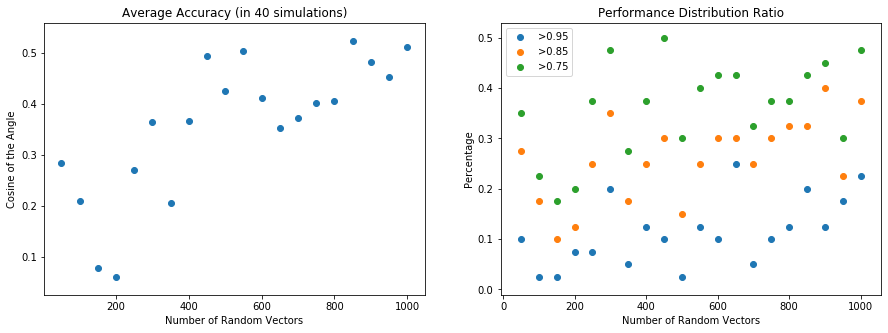

In [176]:
f, ax = plt.subplots(1,2,figsize=(15,5));
ax[0].scatter(range(50, 1050, 50), avg_score2);
ax[0].set_xlabel("Number of Random Vectors");
ax[0].set_ylabel("Cosine of the Angle");
ax[1].scatter(range(50, 1050, 50), stat2_95, label='>0.95');
ax[1].scatter(range(50, 1050, 50), stat2_85, label='>0.85');
ax[1].scatter(range(50, 1050, 50), stat2_75, label='>0.75');
ax[1].set_xlabel("Number of Random Vectors");
ax[1].set_ylabel("Percentage");
ax[1].legend()
ax[0].set_title("Average Accuracy (in 40 simulations)");
ax[1].set_title("Performance Distribution Ratio");
plt.savefig("Huthinson_W2_performance2.png", dpi=200)

In [177]:
M = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000];
dir_w2_dict3 = {1000: 0, 1500: 0, 2000: 0, 2500: 0, 3000: 0, 3500: 0, 
              4000: 0, 4500: 0, 5000: 0};
score_dict3 = {1000: 0, 1500: 0, 2000: 0, 2500: 0, 3000: 0, 3500: 0, 
              4000: 0, 4500: 0, 5000: 0};
for m in M:
    print(m);
    direct_list = [];
    score_list = [];
    for i in range(30):
        direct, score = w2_hut_2(N1, N2, N3, m);
        direct_list.append(direct);
        score_list.append(score);
    dir_w2_dict3[m] = np.array(direct_list);
    score_dict3[m] = np.array(score_list);

1000
1500
2000
2500
3000
3500
4000
4500
5000


In [178]:
np.save("dir_w2_dict3.npy", dir_w2_dict3);
np.save("score_dict3.npy", score_dict3);

In [179]:
dir_w2_dict3 = np.load("dir_w2_dict3.npy", allow_pickle=True);
dir_w2_dict3 = dir_w2_dict3[()];
score_dict3 = np.load("score_dict3.npy", allow_pickle=True);
score_dict3 = score_dict3[()];

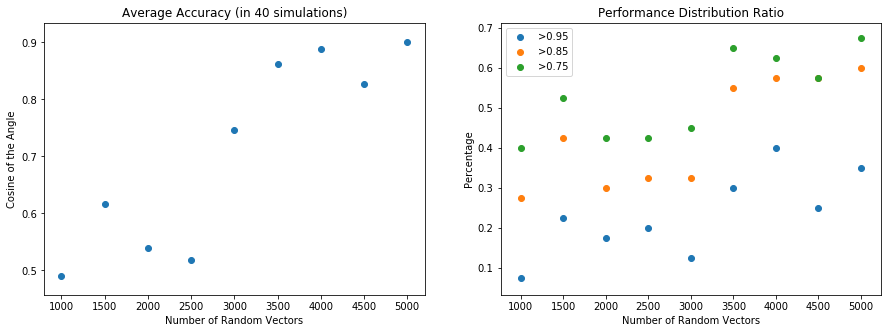

In [181]:
##plot the statistics of our simulations
##we create an array to store the average score of each m
avg_score3 = [];
##we also want to record the percentage of the outputs that are
##>95; >85 >75
stat3_75 = []; stat3_85 = []; stat3_95 = [];
for key in score_dict3:
    avg_score3.append(score_dict3[key].mean());
    stat3_75.append(np.count_nonzero(score_dict3[key] > .75));
    stat3_85.append(np.count_nonzero(score_dict3[key] > .85));
    stat3_95.append(np.count_nonzero(score_dict3[key] > .95));
stat3_75 = np.array(stat3_75)/40;
stat3_85 = np.array(stat3_85)/40;
stat3_95 = np.array(stat3_95)/40;
avg_score3 = np.array(avg_score3);
f, ax = plt.subplots(1,2,figsize=(15,5));
ax[0].scatter(range(1000, 5100, 500), avg_score3);
ax[0].set_xlabel("Number of Random Vectors");
ax[0].set_ylabel("Cosine of the Angle");
ax[1].scatter(range(1000, 5100, 500), stat3_95, label='>0.95');
ax[1].scatter(range(1000, 5100, 500), stat3_85, label='>0.85');
ax[1].scatter(range(1000, 5100, 500), stat3_75, label='>0.75');
ax[1].set_xlabel("Number of Random Vectors");
ax[1].set_ylabel("Percentage");
ax[1].legend()
ax[0].set_title("Average Accuracy (in 40 simulations)");
ax[1].set_title("Performance Distribution Ratio");
plt.savefig("Huthinson_W2_performance3.png", dpi=200)